In [1]:
import torch
from torch import nn
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from himodule.custom_classes import NasaDataset, WindowedLoader, AEConstructor
from himodule.normalisation import StandardScaler, MinMaxScaler, ErrorScaler
from himodule.secondary_funcs import save_object, load_object, check_path, split_dataset, \
    seed_everything, split_anomaly_normal, split_anomaly_normal23

from collections import defaultdict

import os

sns.set_theme(style='whitegrid', font_scale=1.2)

In [2]:
# Check for GPU availability

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


## Plot data

In [3]:
seed = 37
batch_size = 20
window_size = 5

# Whole dataset loading
train_dataset = NasaDataset('../datasets/clean_train_data.csv')

normal_dataset, anomaly_dataset = split_anomaly_normal23(train_dataset)

scaler_path = '../scalers/MinMaxScaler.pkl'
scaler = load_object('../scalers/MinMaxScaler.pkl')
try:
    norm_name = repr(scaler).split(' ', maxsplit=2)[0].split('.')[-1]
except IndexError:
    norm_name = 'no_scaling'

normal_dataset.to(device)
normal_dataset.dataset = scaler.transform(normal_dataset.dataset)

anomaly_dataset.to(device)
anomaly_dataset.dataset = scaler.transform(anomaly_dataset.dataset)

seed_everything(seed)
normal_loader = WindowedLoader(normal_dataset, batch_size=batch_size, window_size=window_size)

seed_everything(seed)
anomaly_loader = WindowedLoader(anomaly_dataset, batch_size=batch_size, window_size=window_size)

print(f'Train: {len(normal_dataset)}')
print(f'Anomaly: {len(anomaly_dataset)}')

input_shape = normal_dataset.get_input_shape()
layers_sizes = (input_shape*window_size//2, input_shape*window_size//4, input_shape*window_size//8)

models_path = f'../Models/window/{len(layers_sizes)+1}'

window_model = AEConstructor(input_shape, window_size=window_size, layers_sizes=layers_sizes)
window_model.load_state_dict(torch.load(os.path.join(models_path, f'{layers_sizes}.pth')))
window_model = window_model.to(device)
loss_func = nn.MSELoss(reduction='none')

Train: 5384
Anomaly: 15247


In [4]:
def get_losses(loader: WindowedLoader, window_model: AEConstructor, loss_func, window_size: int, input_shape: int) -> list:
    losses_dct = defaultdict(list)

    with torch.no_grad():
        for dta in loader:
            sample = dta['sensors']
            indeces = dta['indeces'].flatten()
            _, reconstruction = window_model(sample)
            loss = loss_func(nn.Flatten()(reconstruction), nn.Flatten()(sample))
            loss = loss.view(-1, window_size, input_shape).mean(dim=2).flatten()

            for idx, ls in zip(indeces, loss):
                losses_dct[idx.item()].append(ls.item())
    
    for id, lst in losses_dct.items():
        losses_dct[id] = mean(lst)
    return losses_dct

In [5]:
normal_losses = get_losses(normal_loader, window_model, loss_func, window_size, input_shape)
anomaly_losses = get_losses(anomaly_loader, window_model, loss_func, window_size, input_shape)

In [6]:
normal_losses_df = pd.DataFrame((normal_dataset.machine_ids.cpu().numpy()[np.array(tuple(normal_losses.keys()))],
                                 normal_losses.values(),
                                 ['normal']*len(normal_losses)),
                                 index=('machine_id', 'MSE', 'type')).T

anomaly_losses_df = pd.DataFrame((anomaly_dataset.machine_ids.cpu().numpy()[np.array(tuple(anomaly_losses.keys()))],
                                 anomaly_losses.values(),
                                 ['anomaly']*len(anomaly_losses)),
                                 index=('machine_id', 'MSE', 'type')).T

In [7]:
def get_plot_df(normal_df: pd.DataFrame, anomaly_df: pd.DataFrame, machine_id: int):
    n_df = normal_df[normal_df['machine_id'] == machine_id].loc[:,'MSE':'type']
    a_df = anomaly_df[anomaly_df['machine_id'] == machine_id].loc[:,'MSE':'type']
    
    df = pd.concat((n_df, a_df), axis=0, ignore_index=True)
    return df

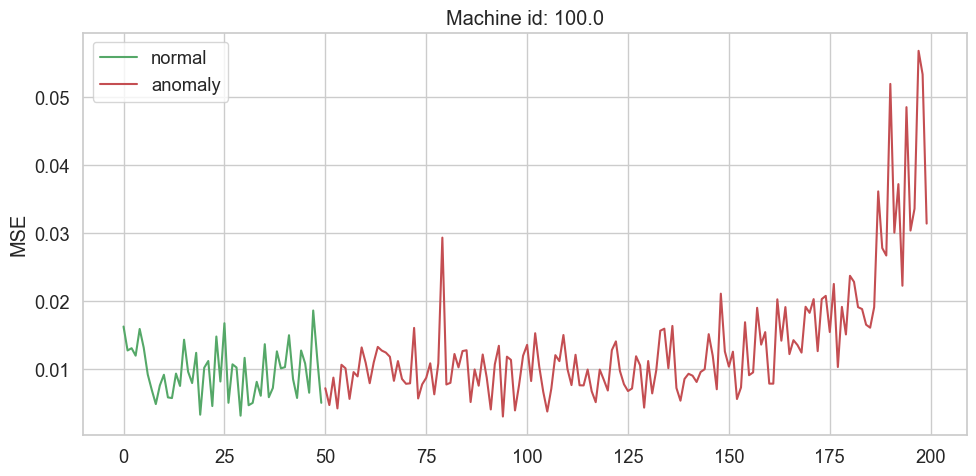

In [58]:
plots_path = '../Plots/window/norm-anom/'
check_path(plots_path)

for machine_id in normal_dataset.machine_ids.unique():
    plot_df = get_plot_df(normal_losses_df, anomaly_losses_df, machine_id)

    plt.close()
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)

    sns.lineplot(data=plot_df,
                 x=plot_df.index,
                 y='MSE',
                 hue='type',
                 palette=('g', 'r'))
    
    ax.legend(title=None)
    ax.set_title(f'Machine id: {machine_id}')

    plt.tight_layout()
    plt.savefig(os.path.join(plots_path, f'{machine_id}.png'))

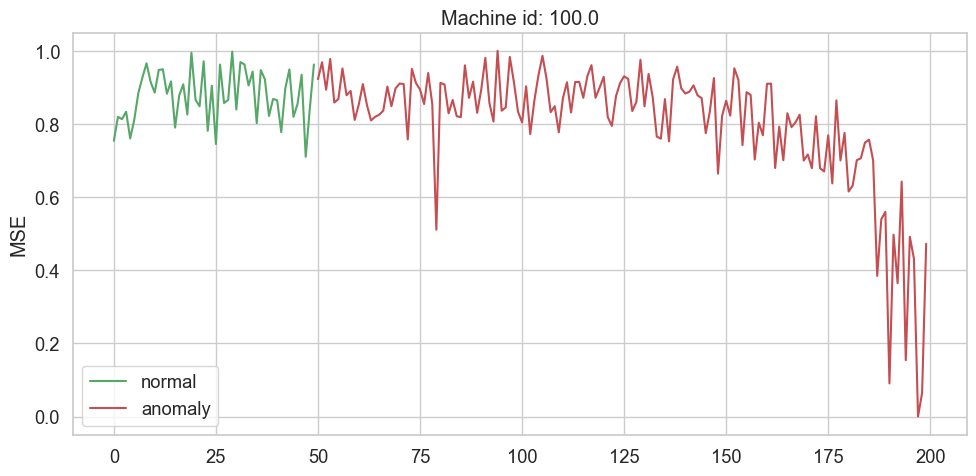

In [8]:
plots_path = '../Plots/window/norm-anom (scaled)/'
check_path(plots_path)

error_scaler = ErrorScaler()

for machine_id in normal_dataset.machine_ids.unique():
    plot_df = get_plot_df(normal_losses_df, anomaly_losses_df, machine_id)

    plot_df['MSE'] = error_scaler.fit_transform(torch.from_numpy(plot_df['MSE'].values.astype(float))).cpu().numpy()

    plt.close()
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)

    sns.lineplot(data=plot_df,
                 x=plot_df.index,
                 y='MSE',
                 hue='type',
                 palette=('g', 'r'))
    
    ax.legend(title=None)
    ax.set_title(f'Machine id: {machine_id}')

    plt.tight_layout()
    plt.savefig(os.path.join(plots_path, f'{machine_id}.png'))

## HI Curves Saving

In [3]:
seed = 37
batch_size = 20
window_size = 5

# Whole dataset loading
train_dataset = NasaDataset('../datasets/clean_train_data.csv')

test_dataset = NasaDataset('../datasets/clean_test_data.csv')

scaler_path = '../scalers/MinMaxScaler.pkl'
scaler = load_object('../scalers/MinMaxScaler.pkl')
try:
    norm_name = repr(scaler).split(' ', maxsplit=2)[0].split('.')[-1]
except IndexError:
    norm_name = 'no_scaling'

train_dataset.to(device)
train_dataset.dataset = scaler.transform(train_dataset.dataset)

test_dataset.to(device)
test_dataset.dataset = scaler.transform(test_dataset.dataset)

seed_everything(seed)
train_loader = WindowedLoader(train_dataset, batch_size=batch_size, window_size=window_size)

seed_everything(seed)
test_loader = WindowedLoader(test_dataset, batch_size=batch_size, window_size=window_size)

print(f'Train: {len(train_dataset)}\nTest: {len(test_dataset)}')

input_shape = train_dataset.get_input_shape()
layers_sizes = (input_shape*window_size//2, input_shape*window_size//4, input_shape*window_size//8)

models_path = f'../Models/window/{len(layers_sizes)+1}'

window_model = AEConstructor(input_shape, window_size=window_size, layers_sizes=layers_sizes)
window_model.load_state_dict(torch.load(os.path.join(models_path, f'{layers_sizes}.pth')))
window_model = window_model.to(device)
loss_func = nn.MSELoss(reduction='none')

Train: 20631,
Test: 13096


In [4]:
def get_losses(loader: WindowedLoader, window_model: AEConstructor, loss_func, window_size: int, input_shape: int) -> list:
    losses_dct = defaultdict(list)

    with torch.no_grad():
        for dta in loader:
            sample = dta['sensors']
            indeces = dta['indeces'].flatten()
            _, reconstruction = window_model(sample)
            loss = loss_func(nn.Flatten()(reconstruction), nn.Flatten()(sample))
            loss = loss.view(-1, window_size, input_shape).mean(dim=2).flatten()

            for idx, ls in zip(indeces, loss):
                losses_dct[idx.item()].append(ls.item())
    
    for id, lst in losses_dct.items():
        losses_dct[id] = mean(lst)
    return losses_dct

In [5]:
train_losses = get_losses(train_loader, window_model, loss_func,
                          window_size=window_size, input_shape=input_shape)
test_losses = get_losses(test_loader, window_model, loss_func,
                          window_size=window_size, input_shape=input_shape)


train_losses = torch.FloatTensor(tuple(train_losses.values()))
test_losses = torch.FloatTensor(tuple(test_losses.values()))

losses = {'train': train_losses, 'test': test_losses}

In [8]:
arrays_path = '../HIs/'
for key in losses.keys():
    check_path(os.path.join(arrays_path, key))

error_scaler = ErrorScaler()

for (sample_type, loss), dataset in zip(losses.items(), (train_dataset, test_dataset)):
    for machine_id in dataset.machine_ids.unique():
        indeces = dataset.get_indeces(machine_id)

        arr = error_scaler.fit_transform(loss[indeces.cpu()]).numpy()
        arr.tofile(os.path.join(arrays_path, sample_type, f'{int(machine_id)}.dat'))